In [ ]:
from pyspark.sql import SparkSession, Row
spark = SparkSession.builder.appName("KMean").getOrCreate()

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import array
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, FloatType
from pyspark.sql.column import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read and explore data

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Final Year/BigData/Hotel_Reservations_15k.csv', header=True, inferSchema=True)
df.printSchema()
df.show()
df = df.drop('arrival_year', 'arrival_month', 'arrival_date')

root
 |-- Booking_ID: string (nullable = true)
 |-- no_of_adults: integer (nullable = true)
 |-- no_of_children: integer (nullable = true)
 |-- no_of_weekend_nights: integer (nullable = true)
 |-- no_of_week_nights: integer (nullable = true)
 |-- type_of_meal_plan: string (nullable = true)
 |-- required_car_parking_space: integer (nullable = true)
 |-- room_type_reserved: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- repeated_guest: integer (nullable = true)
 |-- no_of_previous_cancellations: integer (nullable = true)
 |-- no_of_previous_bookings_not_canceled: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: integer (nullable = true)
 |-- booking_status: string (nullable = true)

+----------+------------+--------------+--

In [ ]:
df.describe().drop('booking_status').show()
nullDF = df.select([(F.count(F.when(F.col(c).isNull(), c)).alias(c)) for c in df.columns])
nullDF.show()

+-------+----------+------------------+-------------------+--------------------+------------------+-----------------+--------------------------+------------------+-----------------+-------------------+--------------------+----------------------------+------------------------------------+------------------+----------------------+
|summary|Booking_ID|      no_of_adults|     no_of_children|no_of_weekend_nights| no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|        lead_time|market_segment_type|      repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|
+-------+----------+------------------+-------------------+--------------------+------------------+-----------------+--------------------------+------------------+-----------------+-------------------+--------------------+----------------------------+------------------------------------+------------------+----------------------+
|  coun

In [ ]:
df.groupBy('booking_status').count().show()

+--------------+-----+
|booking_status|count|
+--------------+-----+
|  Not_Canceled|10134|
|      Canceled| 4866|
+--------------+-----+



## Min-max normalization

In [ ]:
# Calculate max and min value for each row
def calculateMinMax(df, numericCols):
    aggExp = [F.min(col).alias(f'{col}_Min') for col in numericCols] + [F.max(col).alias(f'{col}_Max') for col in numericCols]
    minMaxValue = df.agg(*aggExp).first()
    minMaxDict = {
        col: (minMaxValue[f'{col}_Min'], minMaxValue[f'{col}_Max'])
        for col in numericCols
    }
    return minMaxDict

# Normalize row using Min-max
def normalizeRowMinMax(row, minMaxDict):
    rowDict = row.asDict()
    for col in minMaxDict:
        if col in rowDict:
            minVal, maxVal = minMaxDict[col]
            if maxVal != minVal:
                rowDict[col] = (rowDict[col] - minVal) / (maxVal - minVal)
            else:
                rowDict[col] = 0.0
    return Row(**rowDict)

In [ ]:
# Get columns in numeric type
numCols = [field.name for field in df.schema.fields if isinstance(field.dataType, (FloatType, IntegerType, DoubleType))]
minMaxDict = calculateMinMax(df, numCols)
minMaxDF = df.rdd.map(lambda r: normalizeRowMinMax(r, minMaxDict)).toDF()
print('Min-Max Normalization')
minMaxDF.show()
minMaxDF.describe().show()

Min-Max Normalization
+----------+------------+--------------+--------------------+-------------------+-----------------+--------------------------+------------------+--------------------+-------------------+--------------+----------------------------+------------------------------------+-------------------+----------------------+--------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|  no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|           lead_time|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled| avg_price_per_room|no_of_special_requests|booking_status|
+----------+------------+--------------+--------------------+-------------------+-----------------+--------------------------+------------------+--------------------+-------------------+--------------+----------------------------+------------------------------------+-------------------+----------------------+--------------+


## String Indexer

In [ ]:
STR_COLUMNS = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

# Get unique mappings for each column
def createUniqueMappings(df, cols):
    mappingDFs = {}
    for col in cols:
        mappingDF = (
            df.select(col)
            .distinct()
            .withColumn("index", F.dense_rank().over(Window.orderBy(col)))
        )
        mappingDFs[col] = mappingDF
    return mappingDFs

# Create mapping for string columns
mappingDFs = createUniqueMappings(df, STR_COLUMNS)

# Mapping on dataframe
for col in STR_COLUMNS:
    minMaxDF = minMaxDF.join(mappingDFs[col].withColumnRenamed("index", f"{col}_indexed"), on=col, how="left")
minMaxDF = minMaxDF.drop('type_of_meal_plan', 'room_type_reserved', 'market_segment_type')
minMaxDF.show()

+----------+------------+--------------+--------------------+-------------------+--------------------------+--------------------+--------------+----------------------------+------------------------------------+-------------------+----------------------+--------------+-------------------------+--------------------------+---------------------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|  no_of_week_nights|required_car_parking_space|           lead_time|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled| avg_price_per_room|no_of_special_requests|booking_status|type_of_meal_plan_indexed|room_type_reserved_indexed|market_segment_type_indexed|
+----------+------------+--------------+--------------------+-------------------+--------------------------+--------------------+--------------+----------------------------+------------------------------------+-------------------+----------------------+--------------+-------------------------+------

## Implement KMeans

In [ ]:
class KMeans:
    def __init__(self, k=3, predCol='prediction', seed=1):
        self.k = k
        self.centroids = None
        self.predCol = predCol
        self.seed = seed
        self.wcss = None

    @staticmethod
    def squaredEuclideanDistance(x, y):
        return sum((x[i] - y[i]) ** 2 for i in range(len(x)))

    def clustersDistances(self, features):
        return [self.squaredEuclideanDistance(self.centroids[i], features) for i in range(self.k)]

    def assignToCentroid(self, features):
        distances = self.clustersDistances(features)
        return distances.index(min(distances))

    def fit(self, df, featureCols):
        # Combine feature columns into a single array
        df = df.withColumn('features', F.array(*[F.col(c) for c in featureCols]))
        self.wcss = float('inf')
        self.centroids = None

        for _ in range(5):  # Retry up to 5 times for better initialization
            # Randomly initialize centroids
            centroids = self.centroids
            self.centroids = df.select('features').rdd.map(lambda r: r['features']).takeSample(False, self.k, self.seed)
            self.seed += 1

            while True:
                # Assign points to the nearest centroid
                assignToCentroidUdf = F.udf(self.assignToCentroid, IntegerType())
                df = df.withColumn(self.predCol, assignToCentroidUdf(F.col('features')))

                # Compute new centroids as the mean of points in each cluster
                avgClusters = (
                    df.groupBy(self.predCol)
                    .agg(*[F.mean(c).alias(c) for c in featureCols])
                    .withColumn('avg_features', F.array(*[F.col(c) for c in featureCols]))
                    .collect()
                )
                newCentroids = self.centroids[:]
                for cluster in avgClusters:
                    newCentroids[cluster[self.predCol]] = cluster['avg_features']

                # Check for convergence
                maxChange = max(
                    self.squaredEuclideanDistance(self.centroids[i], newCentroids[i])
                    for i in range(self.k)
                )
                if maxChange ** 0.5 < 1e-4:
                    break

                self.centroids = newCentroids

            # Compute WCSS (Within-Cluster Sum of Squares)
            distUDF = F.udf(
                lambda features, prediction: self.squaredEuclideanDistance(features, self.centroids[prediction]),
                DoubleType(),
            )
            wcss = df.withColumn('dist', distUDF(F.col('features'), F.col(self.predCol))).agg(F.sum('dist')).first()[0]
            if self.wcss > wcss:
                self.wcss = wcss
            else:
                self.centroids = centroids

    def transform(self, df, featureCols):
        df = df.withColumn('features', F.array(*[F.col(c) for c in featureCols]))
        assignToCentroidUdf = F.udf(self.assignToCentroid, IntegerType())
        return df.withColumn(self.predCol, assignToCentroidUdf(F.col('features')))

## Silhouette Coefficient to evaluate clustering

In [ ]:
class SilhouetteEva:
    def __init__(self, predCol='prediction'):
      self.predCol = predCol

    def evaluate(self, df):
      df = df.select('Booking_ID', 'features', self.predCol)
      clusterDF = df.withColumnRenamed('features', 'features_') \
                    .withColumnRenamed(self.predCol, 'cluster') \
                    .withColumnRenamed('Booking_ID', 'Booking_ID_')
      df = df.crossJoin(clusterDF).filter(F.col('Booking_ID') != F.col('Booking_ID_'))
      distanceUDF = F.udf(lambda x, y: sum((x[i]-y[i])**2 for i in range(len(x))), DoubleType())
      df = df.withColumn('dist', distanceUDF(F.col('features'), F.col('features_')))

      # Calculate b(i) - Mean nearest-cluster for each data point
      b = df.filter(F.col(self.predCol) != F.col('cluster')) \
          .groupBy('Booking_ID', 'cluster').agg(F.mean('dist').alias('avg_dist')) \
          .groupBy('Booking_ID').agg(F.min('avg_dist').alias('b_i'))

      # Calculate a(i)- Mean intra-cluster distance for each data point
      a = df.filter(F.col(self.predCol) == F.col('cluster')) \
          .groupBy('Booking_ID').agg(F.mean('dist').alias('a_i'))

      # Calculate mean Silhouette coefficient for clustering
      silhouetteScore = a.join(b, 'Booking_ID') \
                          .withColumn('s_i',(F.col('b_i') - F.col('a_i')) / F.greatest(F.col('a_i'), F.col('b_i'))) \
                          .agg(F.mean('s_i')).first()[0]
      return silhouetteScore

In [ ]:
class ClusterEvaluator:
    def __init__(self, max_k=10, predCol="prediction", seed=42):
        self.max_k = max_k
        self.predCol = predCol
        self.seed = seed

    def evaluateClusters(self, df, featureCols):
        wcssValues = []
        silhouetteScores = []

        for k in range(2, self.max_k + 1):
            # Initialize and fit KMeans
            kmeans = KMeans(k=k, predCol=self.predCol, seed=self.seed)
            kmeans.fit(df, featureCols)

            # Transform the dataset
            clusteredData = kmeans.transform(df, featureCols)

            # Calculate WCSS
            wcssValues.append(kmeans.wcss)

            # Calculate Silhouette Coefficient
            silhouetteEvaluator = SilhouetteEva()
            silhouetteScore = silhouetteEvaluator.evaluate(clusteredData)
            silhouetteScores.append(silhouetteScore)

            print(f"K: {k}, WCSS: {kmeans.wcss}, Silhouette: {silhouetteScore}")

        # Plot Elbow Method
        plt.figure(figsize=(12, 6))
        plt.plot(range(2, self.max_k + 1), wcssValues, marker='o', label='WCSS (Elbow Method)')
        plt.title("Elbow Method")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("WCSS")
        plt.legend()
        plt.show()

        # Plot Silhouette Scores
        plt.figure(figsize=(12, 6))
        plt.plot(range(2, self.max_k + 1), silhouetteScores, marker='o', label='Silhouette Coefficient')
        plt.title("Silhouette Coefficient")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("Silhouette Coefficient")
        plt.legend()
        plt.show()

        # Select the best K based on Silhouette Coefficient
        optimal_k = range(2, self.max_k + 1)[silhouetteScores.index(max(silhouetteScores))]

        return optimal_k, wcssValues, silhouetteScores

## Implement

K: 2, WCSS: 27852.70999125334, Silhouette: 0.7623711928526945
K: 3, WCSS: 12698.527110690622, Silhouette: 0.8351841640930907
K: 4, WCSS: 8884.496831601657, Silhouette: 0.7147655010875497
K: 5, WCSS: 7051.459633960646, Silhouette: 0.7121951857470387


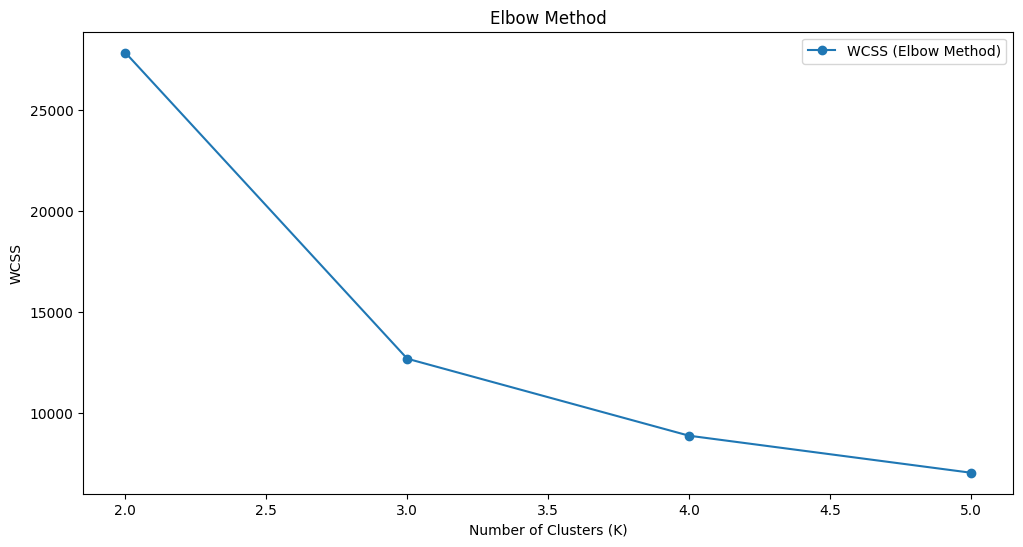

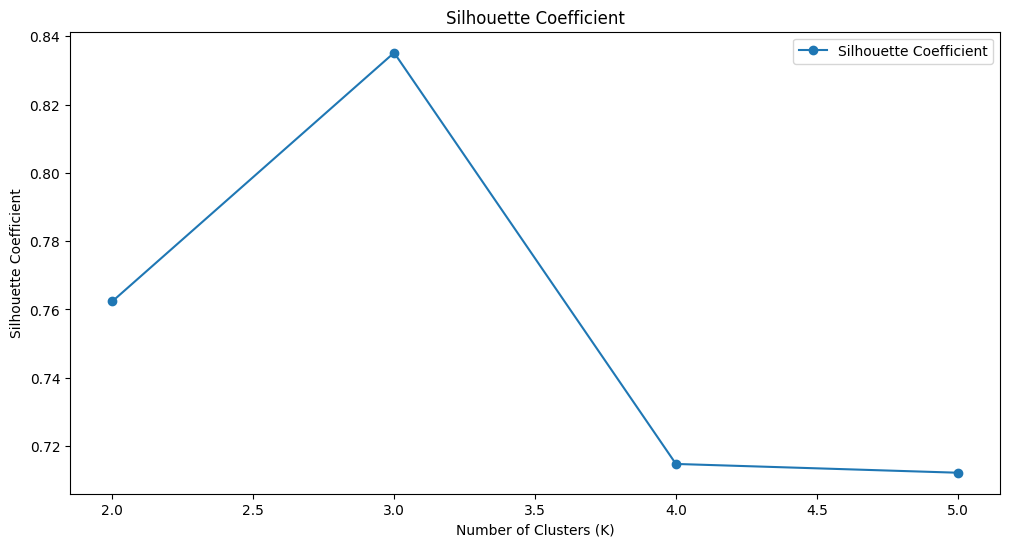

Optimal number of clusters: 3


In [ ]:
featureCols = minMaxDF.columns
featureCols.remove('booking_status')
featureCols.remove('Booking_ID')

clusterEvaluator = ClusterEvaluator(max_k=5, seed=42)
# Evaluate clusters
optimal_k, wcss_values, silhouette_scores = clusterEvaluator.evaluateClusters(minMaxDF, featureCols)

print(f"Optimal number of clusters: {optimal_k}")

In [ ]:
kmeans = KMeans(k=3)
kmeans.fit(minMaxDF, featureCols)

In [ ]:
print('KMean centroids')
for c in kmeans.centroids:
  print(c)
print(f'KMean WCSS: {kmeans.wcss}')

KMean centroids
[0.4371719666563754, 0.007193578264896597, 0.1313334019416143, 0.14439984906179534, 0.029947514665020068, 0.21732385423976935, 0.0336523618400741, 0.0017811765264682808, 0.003425236067502779, 0.2555919471783828, 0.10824328496449982, 1.1235978182566635, 1.0283009159205516, 4.448903982710713]
[0.46765653775322286, 0.0019797421731123396, 0.1298342541436465, 0.13124616329035985, 0.027624309392265192, 0.13414730470714947, 0.007826887661141806, 0.0024082731265051703, 0.0006602036206956462, 0.25070668206663677, 0.14981583793738207, 3.9995395948434624, 1.0064456721915285, 4.953499079189687]
[0.5395371263259402, 0.027097396335583564, 0.15188042430086773, 0.16391299689274097, 0.042751526840244296, 0.1490901359988912, 0.013179042108646738, 0.0007912370496748511, 0.0015526160974751802, 0.35575867770434544, 0.16927033108324932, 1.0790742526518804, 4.364513018322083, 4.772741883638702]
KMean WCSS: 12698.527110690622


In [ ]:
resultDF = kmeans.transform(minMaxDF, featureCols)
resultDF.show(5)

+----------+------------+--------------+--------------------+-------------------+--------------------------+--------------------+--------------+----------------------------+------------------------------------+-------------------+----------------------+--------------+-------------------------+--------------------------+---------------------------+--------------------+----------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|  no_of_week_nights|required_car_parking_space|           lead_time|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled| avg_price_per_room|no_of_special_requests|booking_status|type_of_meal_plan_indexed|room_type_reserved_indexed|market_segment_type_indexed|            features|prediction|
+----------+------------+--------------+--------------------+-------------------+--------------------------+--------------------+--------------+----------------------------+------------------------------------+-------------------+------

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2172|
|         2| 3111|
|         0| 9717|
+----------+-----+



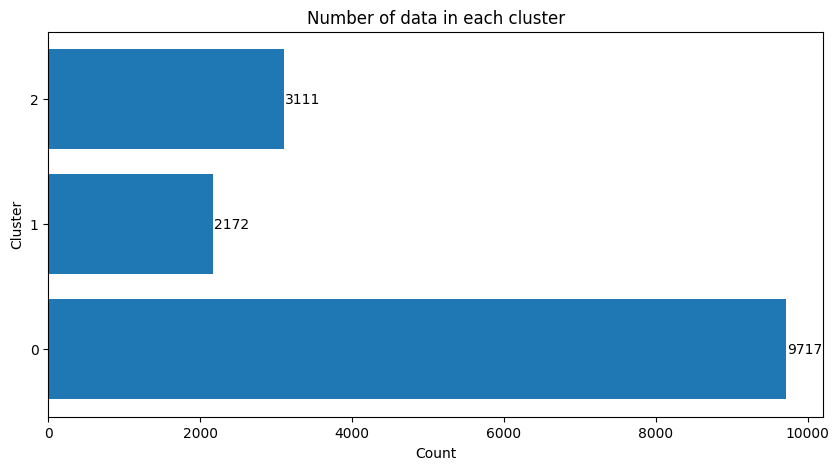



+----------+--------------+-----+
|prediction|booking_status|count|
+----------+--------------+-----+
|         0|      Canceled| 3110|
|         2|      Canceled| 1063|
|         0|  Not_Canceled| 6607|
|         1|  Not_Canceled| 1479|
|         2|  Not_Canceled| 2048|
|         1|      Canceled|  693|
+----------+--------------+-----+



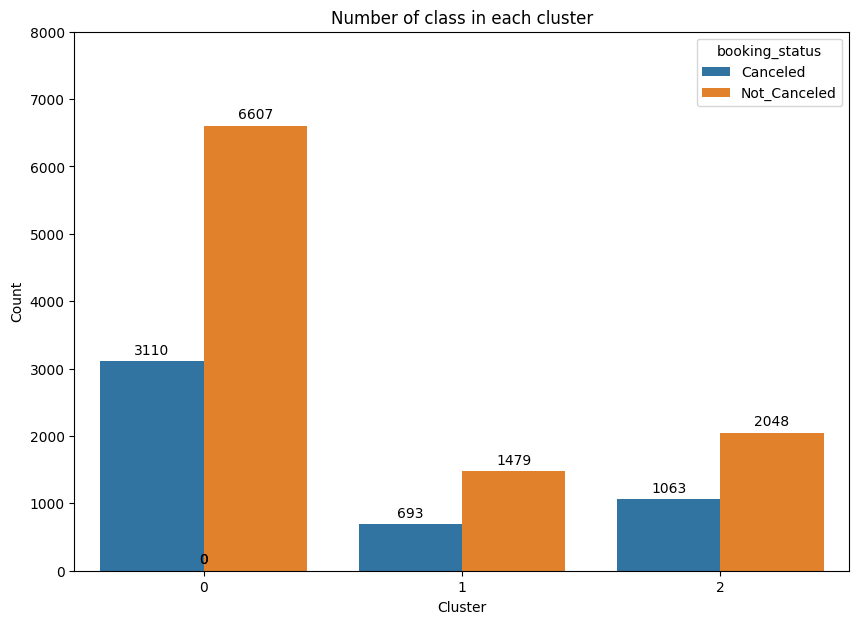

In [ ]:
tempDF = resultDF.groupBy('prediction').count()
tempDF.show()
clusters = tempDF.select('prediction').rdd.flatMap(lambda r: r).collect()
clusterCounts = tempDF.select('count').rdd.flatMap(lambda r: r).collect()
plt.figure(figsize=(10, 5))
bars = plt.barh(clusters, clusterCounts)
plt.yticks(clusters)
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.title('Number of data in each cluster')
for bar in bars:
  plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
plt.show()

print('\n')

tempDF = resultDF.groupBy('prediction', 'booking_status').count()
tempDF.show()
pandasDF = tempDF.toPandas()

# Create a figure and axes
plt.figure(figsize=(10, 7))

# Create a bar plot
barplot = sns.barplot(x='prediction', y='count', hue='booking_status', data=pandasDF)

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of class in each cluster')
plt.yticks(range(0, pandasDF['count'].max() + 2000, 1000))

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 8),
                   textcoords = 'offset points')
plt.show()

In [ ]:
silhouetteEvaluate = SilhouetteEva()
shScore = silhouetteEvaluate.evaluate(resultDF)
print(f'Silhouette Score: {shScore}')

Silhouette Score: 0.8351841640930905


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Combine already indexed columns into a single vector column
vec_assembler = VectorAssembler(inputCols=featureCols, outputCol='features_vec')
df_result2 = vec_assembler.transform(resultDF)

# Evaluate clustering using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features_vec", predictionCol="prediction")
silhouette = evaluator.evaluate(df_result2)

print("Silhouette Score = " + str(silhouette))

Silhouette Score = 0.8351841640930877
